<a href="https://colab.research.google.com/github/Markus-Pobitzer/Inpainting-Tutorial/blob/main/InpaintingTutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Imports and installation of dependencies

In [ ]:
import numpy as np
import requests
import torch
import cv2
from io import BytesIO

# PIL for image manipulation
import PIL
from PIL import Image
from PIL import ImageFilter

from pathlib import Path
from os import makedirs

In [ ]:
#Installing diffusers and transformers library
!pip install diffusers
!pip install transformers
!pip install accelerate

In [ ]:
#Importing diffusers
from diffusers import StableDiffusionInpaintPipeline

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

## Some helper functions

In [ ]:
# Code snippet to dilate (i.e. increase) the mask
def mask_dilation(mask, kernel_size=10):
    mask = mask.astype(np.uint8)
    mask = cv2.dilate(
        mask,
        np.ones((kernel_size, kernel_size), np.uint8),
        iterations=1
    )
    return mask

def pil_dilation(mask, kernel_size=10, invert=False):
    # Depending how the mask is defined we have to first invert it
    if invert:
      mask = PIL.ImageOps.invert(mask)
    mask = np_array_to_pil(mask_dilation(np.array(mask) / 255., kernel_size) * 255).convert("L")
    if invert:
      mask = PIL.ImageOps.invert(mask)
    return mask
    

In [ ]:
# Used for visualization of images
def image_grid(imgs, rows, cols):
    assert len(imgs) == rows * cols

    w, h = imgs[0].size
    grid = Image.new("RGB", size=(cols * w, rows * h))
    grid_w, grid_h = grid.size

    for i, img in enumerate(imgs):
        grid.paste(img.resize((w, h)), box=(i % cols * w, i // cols * h))
    return grid

In [ ]:
def download_image(url):
    response = requests.get(url)
    return PIL.Image.open(BytesIO(response.content)).convert("RGB")

In [ ]:
def np_array_to_pil(image):
    return Image.fromarray(np.uint8(image))

## Download example image and mask

In [ ]:
# Load image and mask
img_url = "https://raw.githubusercontent.com/CompVis/latent-diffusion/main/data/inpainting_examples/overture-creations-5sI6fQgYIuo.png"
mask_url = "https://raw.githubusercontent.com/CompVis/latent-diffusion/main/data/inpainting_examples/overture-creations-5sI6fQgYIuo_mask.png"

init_image = download_image(img_url).resize((512, 512))
mask_image = download_image(mask_url).resize((512, 512))

## runwayml pipeline

See documentation: https://huggingface.co/docs/diffusers/using-diffusers/inpaint

As of today we have two main inpainting pipelines for Stable Diffusion, the one from runwayml and one from stabilityai.

Other options for inpainting with your own Stable Diffusion model include ControNet.

In [ ]:
# This loads the pipeline and laods it onto the GPU
pipeline = StableDiffusionInpaintPipeline.from_pretrained(
    "runwayml/stable-diffusion-inpainting",
)
pipeline = pipeline.to("cuda")

In [ ]:
# Inference with prompt
prompt = "Face of a yellow cat, high resolution, sitting on a park bench"
# For reproducibility
generator = torch.Generator(device='cuda').manual_seed(0)
# Generate inpainting
image = pipeline(prompt=prompt, image=init_image, mask_image=mask_image, generator=generator).images[0]

  0%|          | 0/50 [00:00<?, ?it/s]

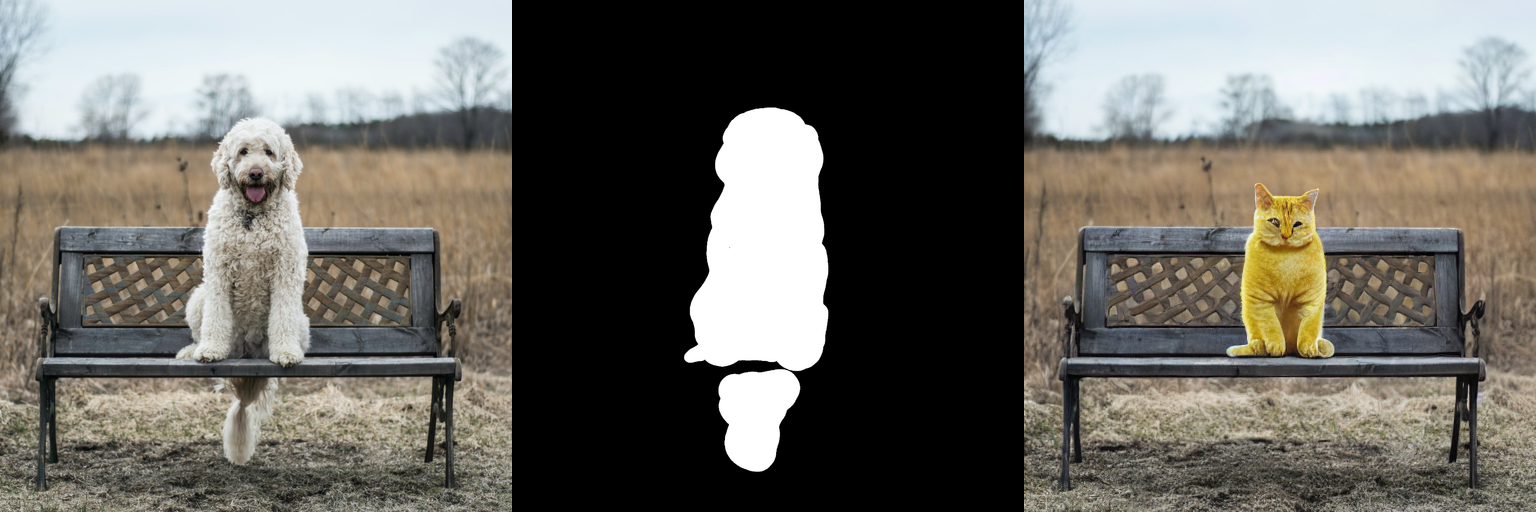

In [ ]:
# visualize input, mask and result
image_grid([init_image, mask_image, image], 1, 3)

## Stabilityai pipeline

See model documentation: https://huggingface.co/stabilityai/stable-diffusion-2-inpainting
        
This is the inpainting pipeline from stability

In [ ]:
# This loads the pipeline and laods it onto the GPU
pipe = StableDiffusionInpaintPipeline.from_pretrained(
    "stabilityai/stable-diffusion-2-inpainting",
    torch_dtype=torch.float16,
)
pipe.to("cuda")

In [ ]:
# Inference with prompt
prompt = "Face of a yellow cat, high resolution, sitting on a park bench"
# For reproducibility
generator = torch.Generator(device='cuda').manual_seed(1)
# Generate inpainting
image = pipe(prompt=prompt, image=init_image, mask_image=mask_image, generator=generator).images[0]

  0%|          | 0/50 [00:00<?, ?it/s]

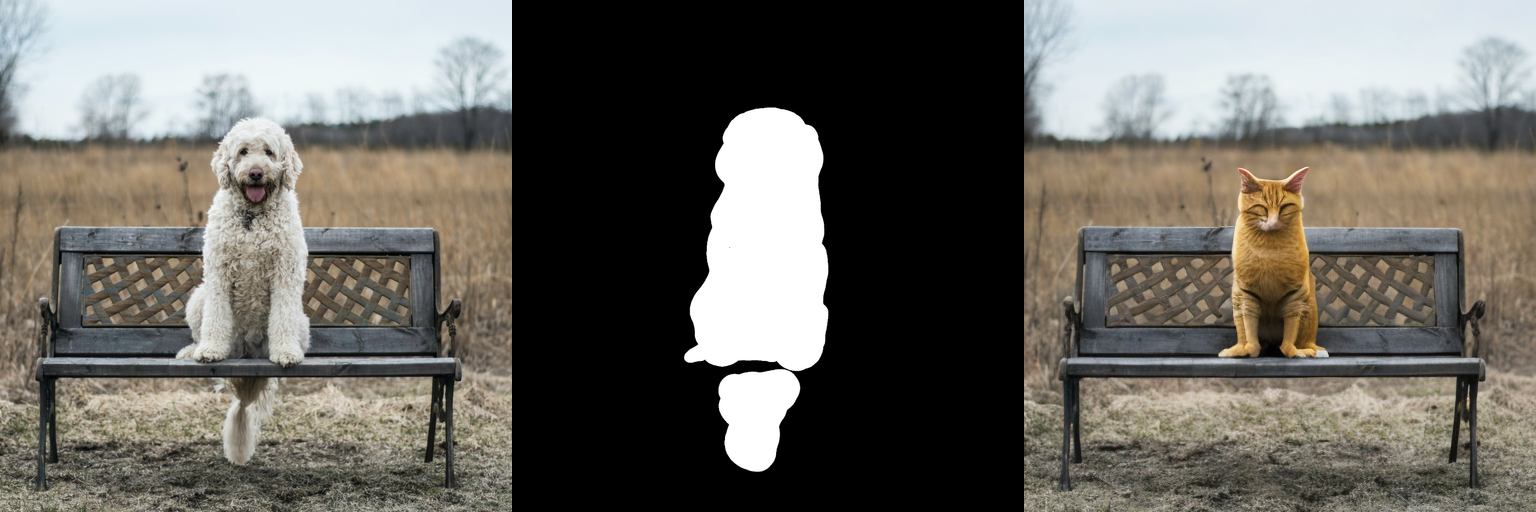

In [ ]:
# visualize input, mask and result
image_grid([init_image, mask_image, image], 1, 3)



---




## Keep original image in unmasked area

Maybe you have noticed it, there are small changes to unmasked area of the inpainted image. The part of the image
that shoould not have changed got slightly modified. I think this mainly stems from the fact that we encode the input image
in a representation that the model can understand (latent space). However, when we decode the inapinted representation
back to an actual image, we loose some information. This latent space does not store as much informationa as the input
image, this makes the whole process faster, but at the same time we loose some information.

The solution: use the original image and put the inpainted part on it. This means we will blend the two images together.

In [ ]:
# This function blends the inpainted image with the original image using the mask
# blur is used to better blend the twom images toghether
def blend_image(inpainted, original, mask, blur=3, dilate=0):
    # Dilates the mask first, i.e. makes the mask bigger
    if dilate:
        mask = np_array_to_pil(mask_dilation(np.array(mask // 255), dilate) * 255)
    mask = mask.convert("L")
    # Apply blur
    mask = mask.filter(ImageFilter.GaussianBlur(blur))
    # Blend images together
    return Image.composite(inpainted.convert('RGBA'), original.convert('RGBA'), mask).convert('RGBA')

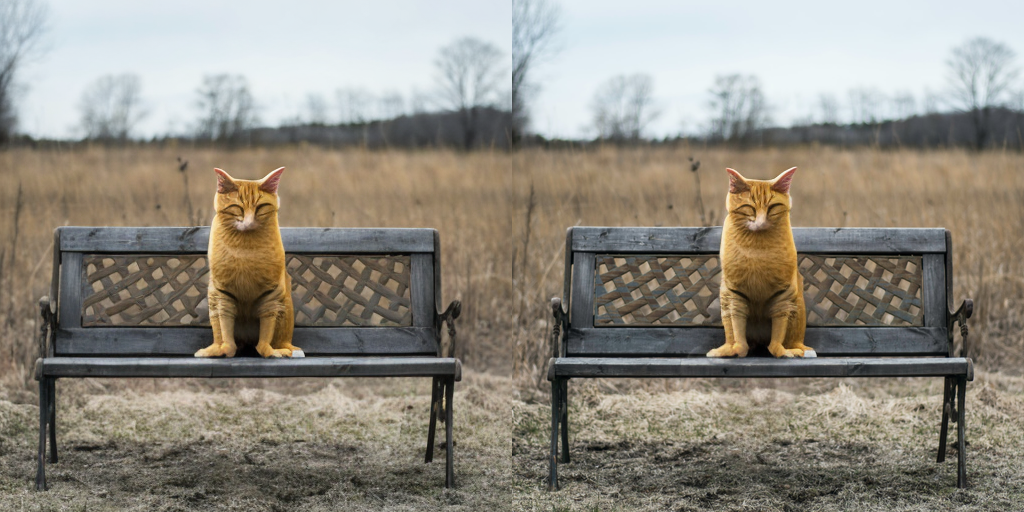

In [ ]:
# Blend the two iamges
blended_image = blend_image(image, init_image, mask_image)
# Display the inpainted and the blended image side by side
# You can notice small changes on the rest of the bench
image_grid([image, blended_image], 1, 2)



---

## Change of background

Assume we want to change the background only. Somteimes it can happen, that the object in the freoground gets continued by the model. This may be an unwantedet change. In the following example we will see how the bottle gets enlarged during the inpainting step.

Solution approches:
1. Increase the mask around the object. This means the model will see part of the original background and has to continue it.
2.  Inpaint the background, let the model embed the object in the foreground as usual. But than we enlarge the mask and inpaint the foreground (i.e. invert the mask) such that we have a simple background where we can easily place the object in.

Disclaimer: Inpainting the background without strange artifacts is highly dependant on the selected mask, the prompt, how well the model knows the object and the seed (you can set it in the generator).

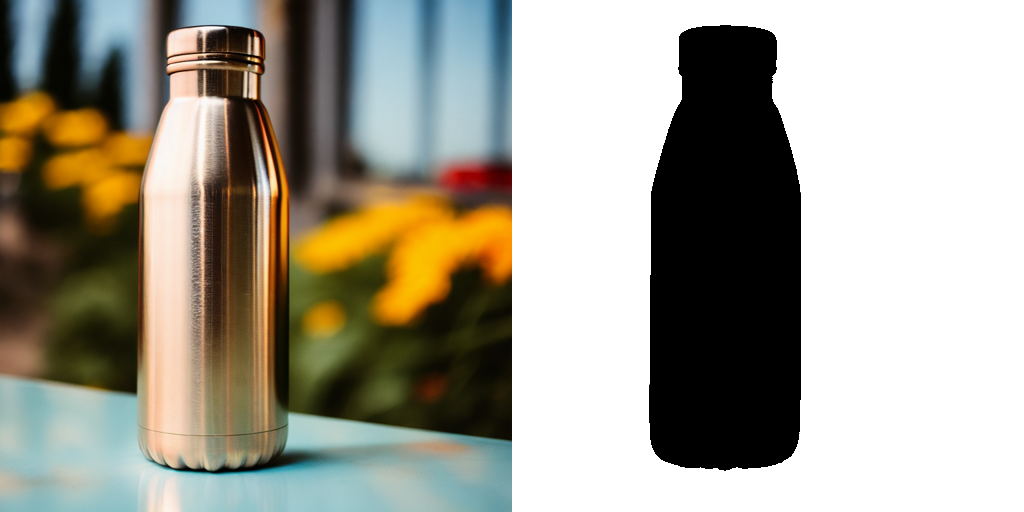

In [110]:
# Load the new image and mask
init_image = download_image("https://raw.githubusercontent.com/Markus-Pobitzer/Inpainting-Tutorial/main/imgs/bottle.png").resize((512, 512))
mask_image = download_image("https://raw.githubusercontent.com/Markus-Pobitzer/Inpainting-Tutorial/main/imgs/bottle_mask.png").resize((512, 512))
# Make sure it conaitns only 0 or 255
mask_image = np_array_to_pil(np.where(np.array(mask_image) > 125, 255, 0)).convert("L")
image_grid([init_image, mask_image], 1, 2)

### Size of mask

For the next steps we will change the size of the mask. To better understand what is happening we can take a short look how the resizing of the mask changes how the model "sees" the input.

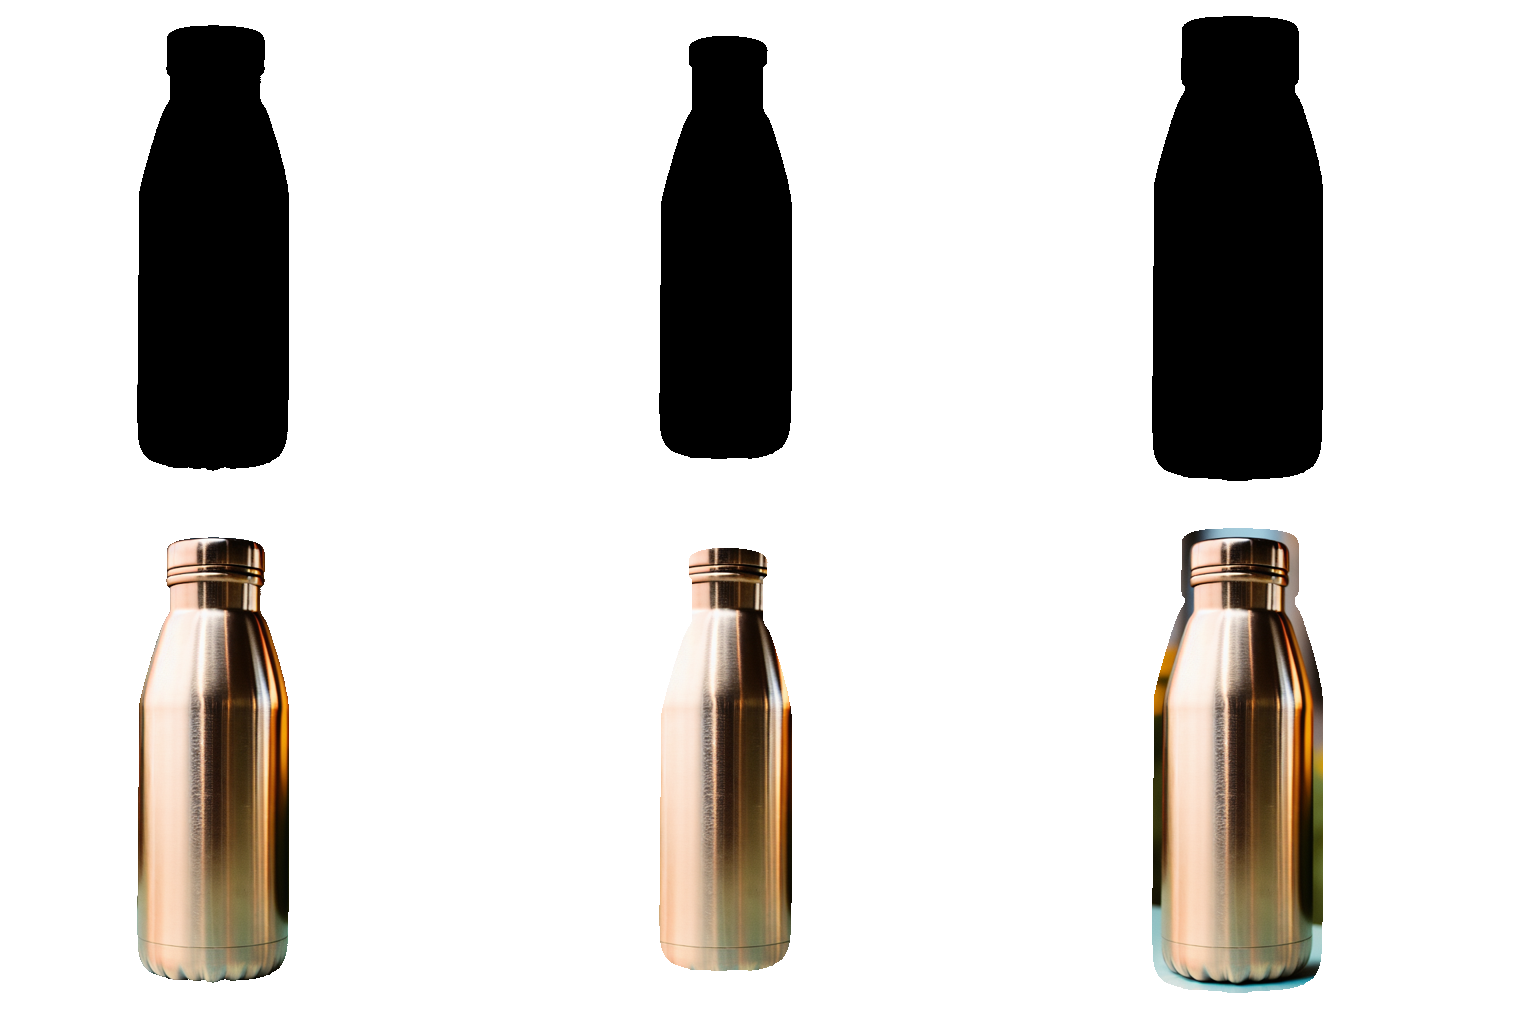

In [127]:
# Mask operations
size = 20
smaller_mask = pil_dilation(mask_image, size, invert=False)
bigger_mask = pil_dilation(mask_image, size, invert=True)
# What the model actually sees
masked = PIL.Image.composite(init_image, mask_image.convert("RGB"), PIL.ImageOps.invert(mask_image))
masked_small = PIL.Image.composite(init_image, smaller_mask.convert("RGB"), PIL.ImageOps.invert(smaller_mask))
masked_big = PIL.Image.composite(init_image, bigger_mask.convert("RGB"), PIL.ImageOps.invert(bigger_mask))

# Now we show the normal mask, a smaller mask and the bigger on. A row below the actual input the model sees
image_grid([mask_image, smaller_mask, bigger_mask, masked, masked_small, masked_big], 2, 3)

### Function

This will be our function for the solutions. It inpaints the object, then it removes the object (and some introduced artifacts) by inpainting. Last we paste the original object onto the empty bakground.

In [128]:
# We define the function where we try out different settings
def change_background(init_image, mask_image, prompt, generator=None, dilation_foreground=0, dilation_background=0):
  # Inpaint the background
  mask_foreground = mask_image
  if dilation_foreground:
    mask_foreground = pil_dilation(mask_foreground, dilation_foreground, invert=True)
  image = pipe(prompt=prompt, image=init_image, mask_image=mask_foreground, generator=generator).images[0]

  # blend image (optional)
  image = blend_image(image, init_image, mask_image)

  # Since we want to inpaint the foreground we have to invert the mask now
  inverted_mask_image = PIL.ImageOps.invert(mask_image)

  # Dilate the mask (to inpaint the foreground object)
  if dilation_background:
    inverted_mask_image = pil_dilation(inverted_mask_image, dilation_background, invert=False)

  # Inpaint the foreground with dilated mask
  image_background = pipe(prompt=prompt, image=image, mask_image=inverted_mask_image, generator=generator).images[0]

  # Blend the foreground object into the image
  image_final = blend_image(image_background, init_image, mask_image)

  return image, mask_foreground, image_background, inverted_mask_image, image_final

### 1. Solution

Here we make the mask aound the object bigger such that th model ha to continue the original background. This reduces the chances that it will continue the object.

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

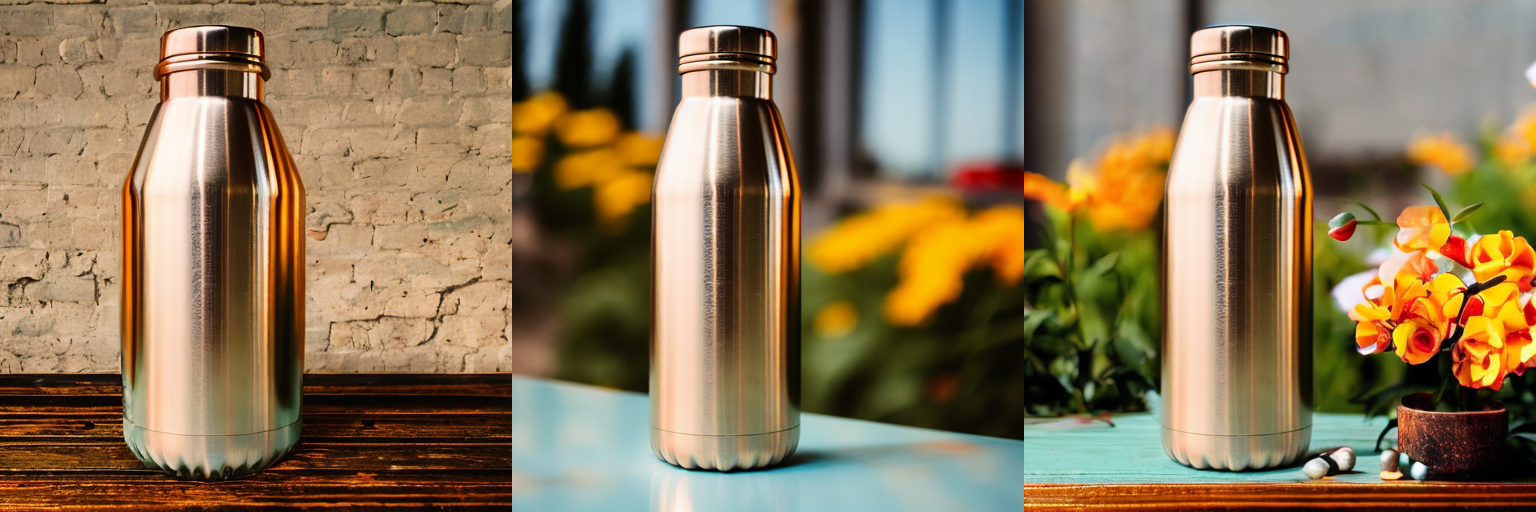

In [133]:
# Now we change the prompt to something that is suitable for inpainting a background
prompt = "photograph of a beautiful empty scene, highest quality settings"

# For reproducibility
generator = torch.Generator(device='cuda').manual_seed(4)

# How much we want to dialte it
# Change this parameter as you need it
dilation_foreground = 10

# Inpainting with normal mask
image_normal = pipe(prompt=prompt, image=init_image, mask_image=mask_image, generator=torch.Generator(device='cuda').manual_seed(4)).images[0]

# Call our function
image, mask_foreground, _, _, _ = change_background(init_image, mask_image, prompt, generator, dilation_foreground=dilation_foreground)

# Visualize our process: normaly inpainted image, the original image, inpainted with a bigger mask
image_grid([image_normal, init_image, image], 1, 3)

As we can see from the three images above, the left most image was inpainted while using the original mask and the bottle became really thick. In the cente we have the original image for comparison and on the right we have the output of the inpainting process with an enlarged mask.

Drawback: Since we also give some information of the background to the model it can not be so creative, i.e. it has learned to contiue the exisiting colors and patterns.

### 2. Solution

Inpaint the background, let the model embed the object in the foreground as usual. But than we enlarge the mask and inpaint the foreground (i.e. invert the mask) such that we have a simple background where we can easily place the object in.


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

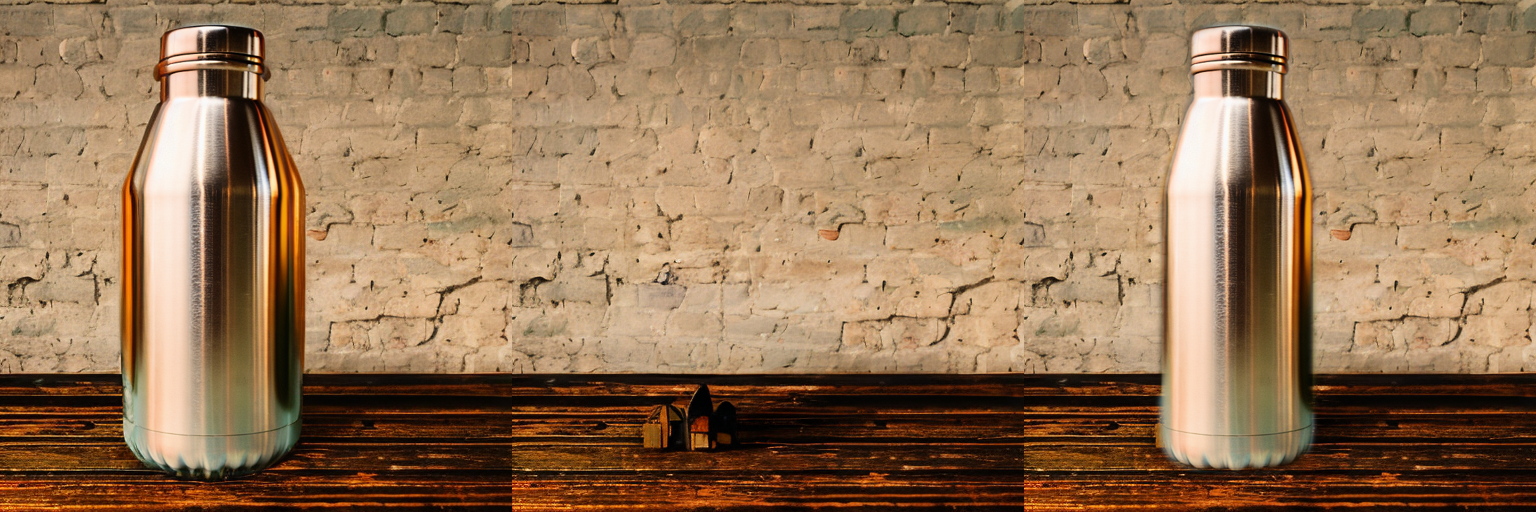

In [138]:
# Now we change the prompt to something that is suitable for inpainting a background
prompt = "photograph of a beautiful empty scene, highest quality settings"

# For reproducibility
generator = torch.Generator(device='cuda').manual_seed(4)

# How much we want to dialte it
dilation_foreground = 0

# Change this parameter as you see fit
dilation_background = 40

# Call our function
image, mask_foreground, image_background, inverted_mask_image, image_final = change_background(init_image, mask_image, prompt, generator, dilation_foreground=dilation_foreground, dilation_background=dilation_background)

# Visualize our process: inpainted image, the background, and final image
image_grid([image, image_background, image_final], 1, 3)

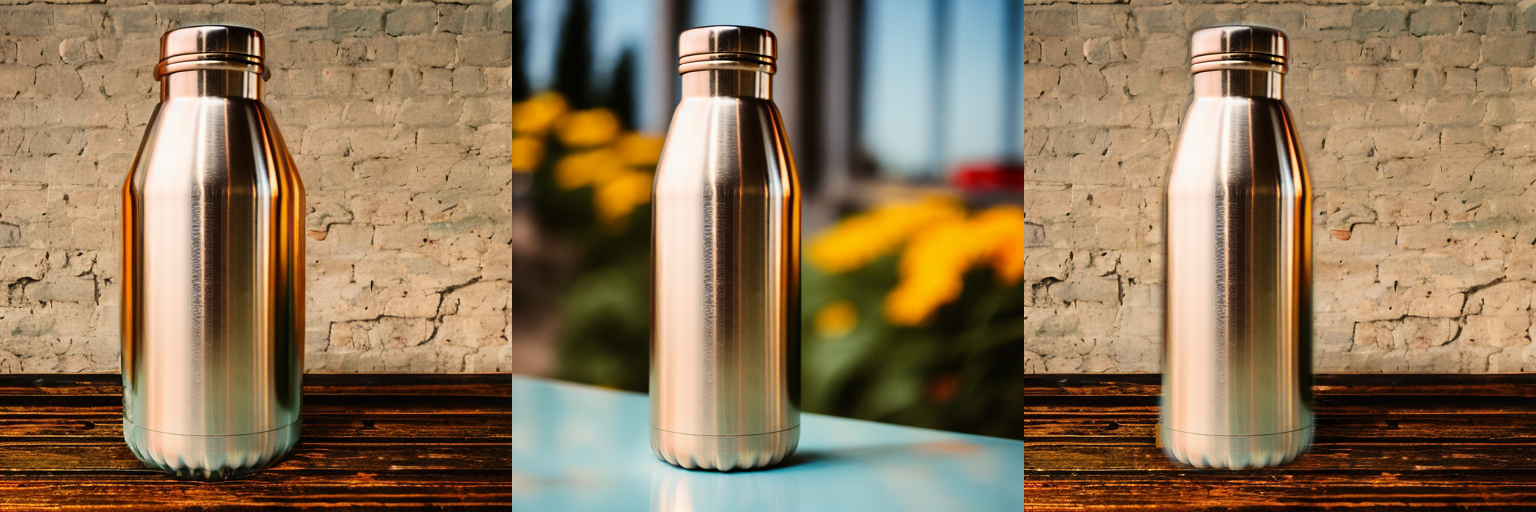

In [139]:
# Compare the first inpainting of the background (left image) with the original image (center) and our result (right image)
image_grid([image, init_image, image_final], 1, 3)